In [32]:
import pickle
import pandas as pd
import numpy as np
import tensorflow as tf
import keras_tuner 
import keras_tuner as kt
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from tensorflow.keras.metrics import AUC, Precision, Recall
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, roc_curve
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from keras_tuner import RandomSearch, HyperParameters
from kerastuner import Objective

In [2]:
# Tải data đã lưu
split_file = "splitted_data.pkl"
print("Tải dữ liệu đã lưu từ:", split_file)

with open(split_file, "rb") as f:
    data_splits = pickle.load(f)

# Lấy các tập dữ liệu từ dictionary
X_train = data_splits["X_train"]
X_val = data_splits["X_val"]
X_test = data_splits["X_test"]
y_train = data_splits["y_train"]
y_val = data_splits["y_val"]
y_test = data_splits["y_test"]
X_train_val = data_splits["X_train_val"]
y_train_val = data_splits["y_train_val"]

Tải dữ liệu đã lưu từ: splitted_data.pkl


In [3]:
# Kiểm tra phân phối của lớp
print("Phân phối lớp trong tập huấn luyện:")
unique, counts = np.unique(y_train_val, return_counts=True)
print(dict(zip(unique, counts)))
print(f"Tỷ lệ dữ liệu dương/âm: 1:{counts[0]/counts[1]:.2f}")

Phân phối lớp trong tập huấn luyện:
{0: 26815, 1: 169}
Tỷ lệ dữ liệu dương/âm: 1:158.67


In [33]:
# Số lượng layer ẩn (từ 1 đến 5)
# Số neuron trong mỗi layer (32 đến 512)
# Hàm kích hoạt (relu, tanh, elu)
# Tỷ lệ dropout (0 đến 0.5)
# Bộ tối ưu hóa (Adam, SGD, RMSprop)
# Tốc độ học (learning rate)

def create_model(hp):
    """
    Hàm tạo mô hình với các siêu tham số có thể điều chỉnh.
    Sử dụng hp.Choice, hp.Int, hp.Float để định nghĩa không gian tìm kiếm.
    """
    model = Sequential()
    
    # Số lượng layer và neuron trong mỗi layer
    num_layers = hp.Int('num_layers', min_value=1, max_value=5, step=1)
    
    # Layer đầu vào
    model.add(Dense(
        units=hp.Int('units_0', min_value=32, max_value=512, step=32),
        activation=hp.Choice('activation_0', values=['relu', 'tanh', 'elu']),
        input_shape=(X_train.shape[1],)
    ))
    
    # Thêm dropout sau layer đầu tiên
    model.add(Dropout(rate=hp.Float('dropout_0', min_value=0.0, max_value=0.5, step=0.1)))
    
    # Các hidden layer
    for i in range(1, num_layers):
        model.add(Dense(
            units=hp.Int(f'units_{i}', min_value=32, max_value=512, step=32),
            activation=hp.Choice(f'activation_{i}', values=['relu', 'tanh', 'elu'])
        ))
        model.add(Dropout(rate=hp.Float(f'dropout_{i}', min_value=0.0, max_value=0.5, step=0.1)))
    
    # Layer đầu ra (giả sử đây là bài toán phân loại nhị phân)
    model.add(Dense(1, activation='sigmoid'))
    
    # Lựa chọn optimizer
    optimizer_name = hp.Choice('optimizer', values=['adam', 'sgd', 'rmsprop'])
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
    
    if optimizer_name == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer_name == 'sgd':
        optimizer = SGD(learning_rate=learning_rate)
    else:
        optimizer = RMSprop(learning_rate=learning_rate)
    
     # THÊM focal loss với gamma và alpha có thể là siêu tham số
    gamma = hp.Float('focal_gamma', 0.0, 5.0, step=0.5, default=2.0)
    alpha = hp.Float('focal_alpha', 0.0, 1.0, step=0.1, default=0.25)
    # Định nghĩa hàm focal loss
    def focal_loss(gamma, alpha):
        def loss(y_true, y_pred):
            y_pred = K.clip(y_pred, K.epsilon(), 1.0 - K.epsilon())
            p_t = tf.where(K.equal(y_true, 1), y_pred, 1 - y_pred)
            alpha_t = tf.where(K.equal(y_true, 1), alpha, 1 - alpha)
            return -alpha_t * K.pow(1.0 - p_t, gamma) * K.log(p_t)
        return loss

    loss_fn = focal_loss(gamma, alpha)

    model.compile(
        optimizer=optimizer,
        loss=loss_fn,
        metrics=[
            tf.keras.metrics.AUC(name='auc'),
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')
        ]
    )
    return model


In [34]:
# Khởi tạo scaler và fit trên X_train
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

# Transform trên X_val và X_test theo thông số đã fit
X_val   = scaler.transform(X_val)
X_test  = scaler.transform(X_test)

In [52]:
# Thiết lập tìm kiếm siêu tham số
tuner = RandomSearch(
    create_model,
    objective=Objective('val_auc', direction='max'),
    max_trials=20,  # Số lượng mô hình khác nhau để thử
    executions_per_trial=2,  # Số lần chạy mỗi mô hình để lấy trung bình
    directory='mlp_tuning',
    project_name='mlp_hyperparameters'
)

# Callback dừng sớm để tránh overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Bắt đầu tìm kiếm
tuner.search(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]
)

# Lấy mô hình tốt nhất
best_model = tuner.get_best_models(num_models=1)[0]

# In ra các siêu tham số tốt nhất
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Siêu tham số tốt nhất:")
for param, value in best_hyperparameters.values.items():
    print(f"{param}: {value}")


Reloading Tuner from mlp_tuning\mlp_hyperparameters\tuner0.json
Siêu tham số tốt nhất:
num_layers: 3
units_0: 480
activation_0: elu
dropout_0: 0.1
optimizer: adam
learning_rate: 0.0004933580644287955
focal_gamma: 1.5
focal_alpha: 0.8
units_1: 192
activation_1: tanh
dropout_1: 0.4
units_2: 416
activation_2: tanh
dropout_2: 0.1
units_3: 32
activation_3: elu
dropout_3: 0.4
units_4: 512
activation_4: tanh
dropout_4: 0.30000000000000004


211/211 [==============================] - 0s 1ms/step
Ngưỡng dự đoán tối ưu: 0.3993

=== Classification Report on Test ===
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      6705
           1       0.13      0.21      0.16        42

    accuracy                           0.99      6747
   macro avg       0.56      0.60      0.58      6747
weighted avg       0.99      0.99      0.99      6747



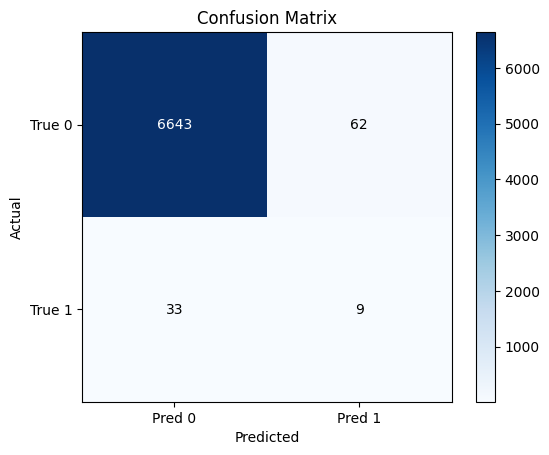

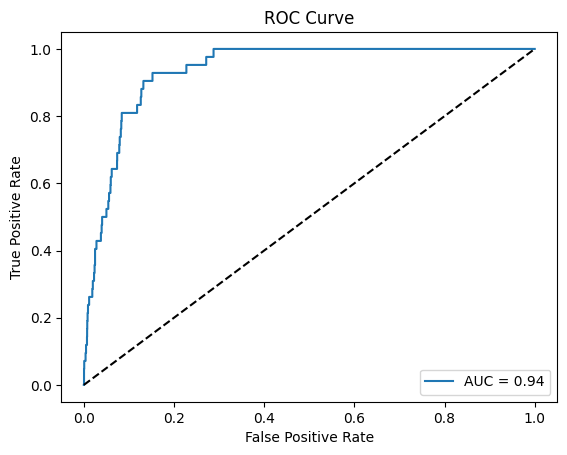

In [51]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, auc

# Dự đoán trên test 
y_prob = best_model.predict(X_test).ravel()

# Tìm ngưỡng tối ưu sử dụng precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
f1_scores = 2 * recall * precision / (recall + precision + 1e-10)
optimal_threshold_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_threshold_idx]
print(f"Ngưỡng dự đoán tối ưu: {optimal_threshold:.4f}")

# Áp dụng ngưỡng tối ưu
y_pred = (y_prob > optimal_threshold).astype(int)

# Classification Report
print("\n=== Classification Report on Test ===")
print(classification_report(y_test, y_pred, zero_division=0)) 

# Confusion Matrix 
cm = confusion_matrix(y_test, y_pred)  
fig, ax = plt.subplots()
im = ax.imshow(cm, cmap='Blues')
plt.colorbar(im, ax=ax)
ax.set(
    xticks=[0,1], yticks=[0,1],
    xticklabels=['Pred 0','Pred 1'],
    yticklabels=['True 0','True 1'],
    title='Confusion Matrix',
    xlabel='Predicted', ylabel='Actual'
)
thresh = cm.max() / 2
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i,j],
                ha='center', va='center',
                color='white' if cm[i,j] > thresh else 'black')
plt.show()

# ROC Curve 
fpr, tpr, _ = roc_curve(y_test, y_prob) 
roc_auc      = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


In [55]:
# Áp dụng SMOTE trên tập train
smote = SMOTE()
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Thiết lập tìm kiếm siêu tham số
tuner = RandomSearch(
    create_model,
    objective=Objective('val_auc', direction='max'),
    max_trials=20,  # Số lượng mô hình khác nhau để thử
    executions_per_trial=2,  # Số lần chạy mỗi mô hình để lấy trung bình
    directory='mlp_tuning_smote',
    project_name='mlp_hyperparameters_smote'
)

# Callback dừng sớm để tránh overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Bắt đầu tìm kiếm
tuner.search(
    X_train_smote, y_train_smote,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]
)

# Lấy mô hình tốt nhất
best_model_smote = tuner.get_best_models(num_models=1)[0]

# In ra các siêu tham số tốt nhất
best_hyperparameters_smote = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Siêu tham số tốt nhất:")
for param, value in best_hyperparameters.values.items():
    print(f"{param}: {value}")

Reloading Tuner from mlp_tuning_smote\mlp_hyperparameters_smote\tuner0.json
Siêu tham số tốt nhất:
num_layers: 3
units_0: 480
activation_0: elu
dropout_0: 0.1
optimizer: adam
learning_rate: 0.0004933580644287955
focal_gamma: 1.5
focal_alpha: 0.8
units_1: 192
activation_1: tanh
dropout_1: 0.4
units_2: 416
activation_2: tanh
dropout_2: 0.1
units_3: 32
activation_3: elu
dropout_3: 0.4
units_4: 512
activation_4: tanh
dropout_4: 0.30000000000000004


211/211 [==============================] - 0s 831us/step
Ngưỡng dự đoán tối ưu: 0.6140

=== Classification Report on Test ===
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      6705
           1       0.19      0.19      0.19        42

    accuracy                           0.99      6747
   macro avg       0.59      0.59      0.59      6747
weighted avg       0.99      0.99      0.99      6747



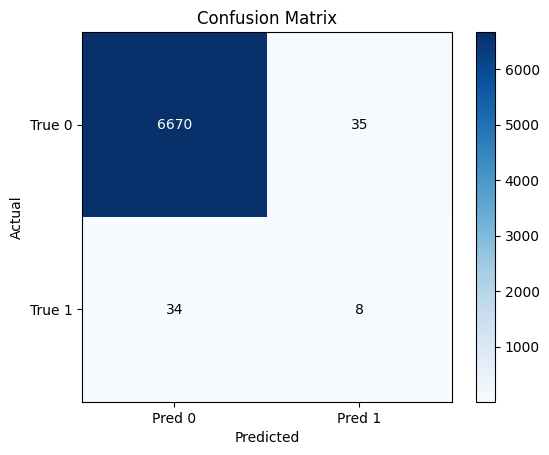

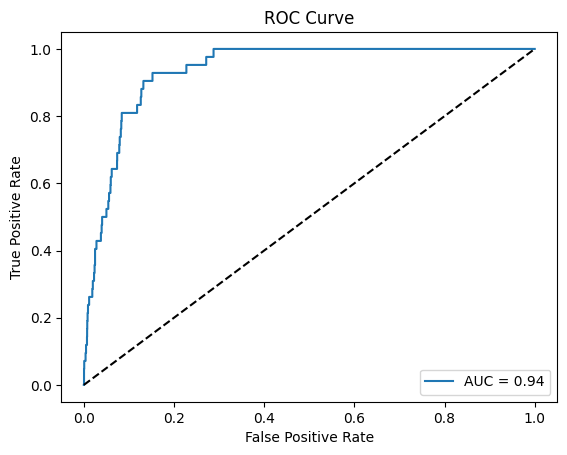

In [57]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, auc

# Dự đoán trên test 
y_prob_smote = best_model_smote.predict(X_test).ravel()

# Tìm ngưỡng tối ưu sử dụng precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_prob_smote)
f1_scores = 2 * recall * precision / (recall + precision + 1e-10)
optimal_threshold_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_threshold_idx]
print(f"Ngưỡng dự đoán tối ưu: {optimal_threshold:.4f}")

# Áp dụng ngưỡng tối ưu
y_pred_smote = (y_prob_smote > optimal_threshold).astype(int)

# Classification Report
print("\n=== Classification Report on Test ===")
print(classification_report(y_test, y_pred_smote, zero_division=0)) 

# Confusion Matrix 
cm = confusion_matrix(y_test, y_pred_smote)  
fig, ax = plt.subplots()
im = ax.imshow(cm, cmap='Blues')
plt.colorbar(im, ax=ax)
ax.set(
    xticks=[0,1], yticks=[0,1],
    xticklabels=['Pred 0','Pred 1'],
    yticklabels=['True 0','True 1'],
    title='Confusion Matrix',
    xlabel='Predicted', ylabel='Actual'
)
thresh = cm.max() / 2
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i,j],
                ha='center', va='center',
                color='white' if cm[i,j] > thresh else 'black')
plt.show()

# ROC Curve 
fpr, tpr, _ = roc_curve(y_test, y_prob) 
roc_auc      = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()